In [1]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from Bio import SeqIO
import pysam 
import glob
from collections import defaultdict
import operator
import numpy as np
import pandas as pd


In [2]:
names = {"NC_050263.1":"Hystrix_brachyura",
        "NC_021478.1":"Rhizomys_pruinosus",
        "KX964606.1":"Erinaceus_amurensis",
        "NC_020645.1":"Arctonyx_collaris",
        "NC_029403.1":"Paguma_larvata",
        "NC_018367.1":"Marmota_himalayana",
        "NC_013700.1":"Nyctereutes_procyonoides"}

In [3]:
refs = {}
for r in SeqIO.parse('./mitochondria_dereplicated93_final.fasta', 'fasta'):
    if r.id in names:
        refs[r.id] = str(r.seq)


coverage_final = {}
snvs_final = {}

results = defaultdict(list)

for bam_file_name in glob.glob('./bams_and_snvs/*.bam'):
    found = False
    for species in names:
        if names[species] in bam_file_name:
            found = True
            break
    
    if found:
        print(bam_file_name)
        samfile = pysam.AlignmentFile(bam_file_name, "rb")
        cov = 0
        coverages = []
        sequence = defaultdict(lambda: "N")
        for pileupcolumn in samfile.pileup(species, min_base_quality=20): ## Contig name
            bases = {"A":0,"C":0,"T":0,"G":0}
            for pileupread in pileupcolumn.pileups:
                if not pileupread.is_del and not pileupread.is_refskip:
                    base = pileupread.alignment.query_sequence[pileupread.query_position]
                    if base in bases:
                        bases[base] += 1

            coverages.append(sum(bases.values()))

            best_base = max(bases.items(), key=operator.itemgetter(1))[0]
            tie_found = False
            for base in bases:
                if base != best_base and bases[base] == bases[best_base]:
                    tie_found = True # ties count as N

            if bases[best_base] >= 1 and not tie_found: # At least one base - change to 3 for high confidence calls
                sequence[pileupcolumn.reference_pos] = best_base
                cov += 1

        i = 0
        final = ''
        coverage = []
        snvs = []
        last_end = 0
        found_seq = False
        for b in refs[species]:
            if sequence[i] == 'N' and found_seq:
                coverage.append((last_end,i))
                found_seq = False
            elif sequence[i] != 'N':
                if sequence[i] != refs[species][i]:
                    snvs.append(i)
                if not found_seq:
                    found_seq = True
                    last_end = i
                    
            i += 1
            
        srr = bam_file_name.split("/")[-1].split("_")[2]
        coverage_final[names[species] + "_" + srr + "_" + str(len(refs[species]))] = coverage
        snvs_final[names[species] + "_" + srr + "_" + str(len(refs[species]))] = snvs
        
        results['sample'].append(srr)
        results['species'].append(names[species])
        results['coverage'].append(cov)
        results['percentage'].append(cov / len(refs[species]))
        
        results['name'].append(names[species] + "_" + srr + "_" + str(len(refs[species])))
results = pd.DataFrame(results)

FileNotFoundError: [Errno 2] No such file or directory: './mitochondria_dereplicated93_final.fasta'

In [13]:
lab = pd.read_csv('../metadata/Liu_etal_2023_with_sequencing.csv', sep=",")
labs = {}
stalls = {}
samples = {}
for index, row in lab[~lab.Sequencing_Run.isna()].iterrows():
    labs[row['Sequencing_Run']] = row['Sample.information']
    stalls[row['Sequencing_Run']] = row['Stall_corrected']
    samples[row['Sequencing_Run']] = row['Lab.code']

In [16]:
colors = {"Hystrix":"#2ca05a",
        "Rhizomys":"#d4aa00",
        "Erinaceus":"#5f8dd3",
        "Arctonyx":"#b97dde",
        "Paguma":"#c83771",
        "Marmota":"#52c0d1",
        "Nyctereutes":"#d35f5f"}

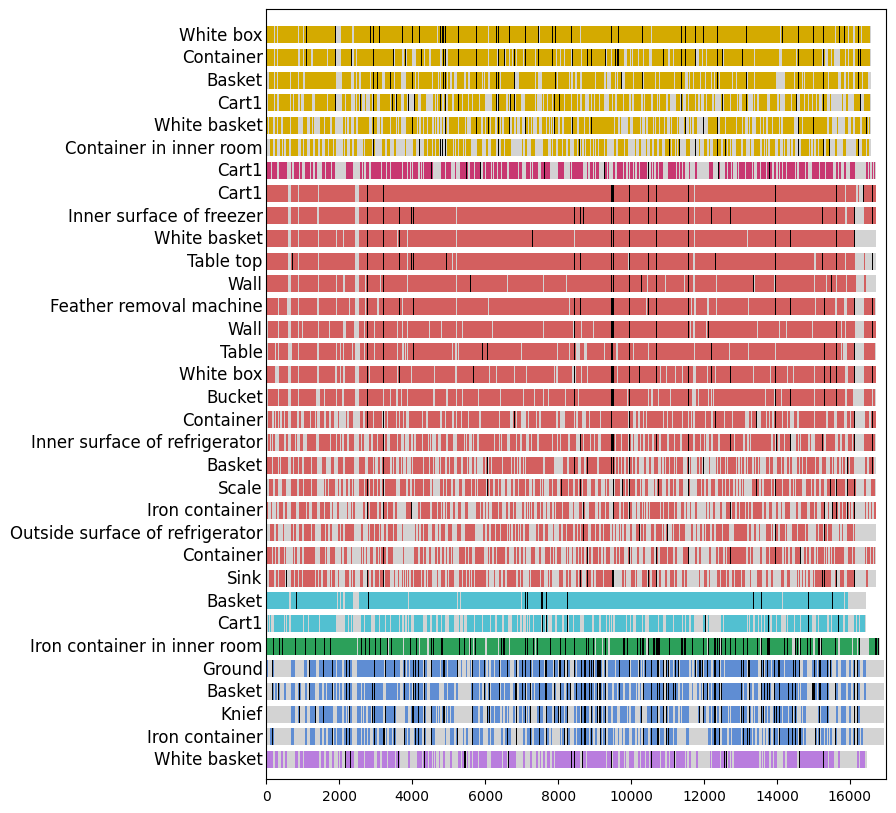

In [17]:
plt.rcParams["figure.figsize"] = (8,10)
plt.rcParams['svg.fonttype'] = 'none'

good_hits = results.sort_values(['species', 'coverage'], ascending=True).query("percentage > 0.5").name.to_list()
fig = plt.figure()
plt.xlim(0, 17000)
plt.ylim(0, len(good_hits)*2+2)
plt.yticks([])

currentAxis = plt.gca()
i = 0
k = 1
for title in good_hits:
    plt.text(-100, k+0.3, labs[title.split("_")[-2]], fontsize=12, ha='right')
    currentAxis.add_patch(Rectangle((0, k), int(title.split("_")[-1]), 1.5, facecolor="lightgrey"))
    for cov in coverage_final[title]:
        currentAxis.add_patch(Rectangle((cov[0], k), cov[1]-cov[0], 1.5, facecolor=colors[title.split("_")[0]]))
        i += 1
    for snv in snvs_final[title]:
        currentAxis.add_patch(Rectangle((snv-5, k), 10, 1.5, facecolor="black"))
    k += 2
    
# plt.savefig("MT_genomes.svg")

In [27]:
snvs = []
for index, row in results.iterrows():
    snvs.append(len(snvs_final[row['name']]))
    
results['snvs'] = snvs
results['divergence'] = results['snvs'] / results['coverage'] * 100
results['Lab_code'] = results['sample'].map(samples)
results['Stall'] = results['sample'].map(stalls)


In [28]:
results.query("percentage > 0.5").divergence.min()

0.16311735387403717

In [29]:
results.query("percentage > 0.5").divergence.max()

2.050280693190139

In [30]:
results.query("percentage > 0.5").divergence.mean()

0.5670801250815327

In [32]:
results.query("percentage >= 0.5").to_csv("Mitochondrial_genomes.tsv", index=None, sep="\t")